In [1]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

### Initial conditions

In [2]:
skills = {1:{'p':0.1, 'v':240}, 
          2:{'p':0.2, 'v':120}, 
          3:{'p':0.3, 'v':80}, 
          4:{'p':0.4, 'v':60}, 
          5:{'p':0.5, 'v':48},
          6:{'p':0.6, 'v':40}}

In [3]:
def initial_wealth_distribution():
    return max(0,np.random.randn()*100+100)
#def initial_payroll():
    #mean = $50,000/12 ≈ $4,150, sd = $20,000/12 ≈ $1,650
    #return min(max(0,np.random.randn()*1.65+4.15), 17)
def initial_capital():
    return max(0,np.random.randn()*165+415)
cost_of_living = 1

### Simulating network

Note: money is in $ 1000

In [4]:
def initiate(num_people, num_companies):
    G = nx.Graph()
    n = num_people + num_companies
    G.add_nodes_from(np.arange(0,n))
    people_index = np.arange(0,num_people)
    company_index = np.arange(num_people,n)
    P = [{"money": initial_wealth_distribution(), 
          "skills":[skill for skill in skills 
                    if np.random.random() < skills[skill]['p']],
          "jobs": [],
          "salary": 0,
          "job_offers":{}} for i in range(num_people)]
    C = [{"capital": initial_capital(), "employees":[], "applications":[]} 
         for i in range(num_companies)]
    return G, P, C, people_index, company_index

In [5]:
def marginal_contribution_of_employee(c, v):
    return 24 * (np.sqrt((C[c]["capital"])**2+v) - C[c]["capital"])

In [6]:
def hire(c, v):
    #print(marginal_contribution_of_employee(c, v), c)
    if marginal_contribution_of_employee(c, v) > 0: #task: decide the criteria
        if np.random.random() > 0.5:
            return 1
    return 0

In [7]:
def leisure_vs_consumption():
    leisure = np.random.random()
    consumption = 1 - leisure
    return leisure, consumption

In [8]:
def evolve(G, P, C, people_index, company_index, tax_rate, corporate_tax_rate):
    
    values = np.zeros(num_people)
    
    for person in people_index:
        values[person] = sum([skills[i]['v'] for i in P[person]['skills']])
        leisure, consumption = leisure_vs_consumption()
        money = P[person]["money"]
        salary = P[person]["salary"]
        
        #the person looks for a job
        if P[person]['jobs'] != [] or money + salary <= cost_of_living:
            for company in company_index:
                company_arg = company - num_people
                #if the person needs a job to pay the costs of living, then he must apply for it
                if money - cost_of_living <= 0 and tax_rate<1:
                    C[company_arg]['applications'].append(person)
                #person considers the tax rate while weighing tradeoffs
                elif np.sqrt(money**2 + marginal_contribution_of_employee(company_arg, values[person])*(1-tax_rate))-money > 0.01: #task: decide the criteria
                    C[company_arg]['applications'].append(person)    
                   
                #print(np.sqrt(money**2 + marginal_contribution_of_employee(company_arg, values[person])*(1-tax_rate))-money)
        
        elif money > cost_of_living:
            if leisure > consumption:
                for job in P[person]['jobs']:   
                    edge = (job, person)
                    G.remove_edge(*edge)
                    
                P[person]['jobs'] = []
                P[person]['salary'] = 0
        
    #companies consider applicants
    for company in company_index:
        company_arg = company - num_people
        for applicant in C[company_arg]["applications"]:
            if hire(company_arg, values[applicant]):
                P[applicant]['job_offers'][company] = marginal_contribution_of_employee(company_arg, values[applicant]) #salaries do not mention income taxes
        
        #print(C[company_arg]["applications"])      
        C[company_arg]["applications"] = []
   
    government_revenue = 0

    #person accepts or rejects job offers
    for person in people_index:
        job_offers = P[person]['job_offers']
        #print(job_offers)
        best_offer  = 0
        best_provider = None
        
        if job_offers != {}:
            for offer in job_offers:
                if job_offers[offer] > best_offer:
                    best_offer = job_offers[offer]
                    best_provider = offer
            
            #we assume if a person already has a job he has to drop it for accepting a new job
            for job in P[person]['jobs']:
                C[job-num_people]['employees'].remove(person)
                
                edge = (job, person)
                G.remove_edge(*edge)
            
            P[person]['jobs'] = [best_provider]
            P[person]['salary'] = best_offer
            
            C[best_provider - num_people]['employees'].append(person)
        
            edge = (best_provider, person)
            G.add_edge(*edge)
        
            P[person]['job_offers'] = {}
        
        P[person]['money'] += P[person]['salary']*(1-tax_rate)
        
        for i in range(len(P[person]['jobs'])):
            C[P[person]['jobs'][i]-num_people]['capital'] -= P[person]['salary']
            #works only for one job at a time
        
        government_revenue += P[person]['salary']*tax_rate
        
        #subtract cost of living
        P[person]["money"] -= cost_of_living
        
    #profit mechanism
    for company in company_index:
            company_arg = company-num_people
            for employee in C[company_arg]['employees']:
                profit = marginal_contribution_of_employee(company_arg, values[employee])*2
                C[company_arg]['capital'] += profit*(1-corporate_tax_rate)
                government_revenue += profit*corporate_tax_rate
                
        
    #redistribution
    for person in people_index:
        P[person]['money'] += government_revenue/num_people
    
    return G, P, C

In [9]:
income_tax_rate = 0.25
corporate_tax_rate = 0.2

num_people = 100
num_companies = 10

G, P, C, people_index, company_index = initiate(num_people, num_companies)

for i in range(500):
    G, P, C = evolve(G, P, C, people_index, company_index, income_tax_rate, corporate_tax_rate)

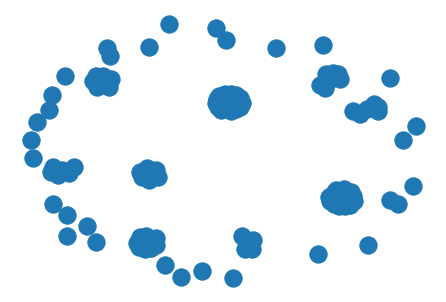

In [10]:
nx.draw(G)
plt.show()

In [11]:
#print("Nodes of graph: ")
#print(G.nodes())
#print("Edges of graph: ")
#print(G.edges())

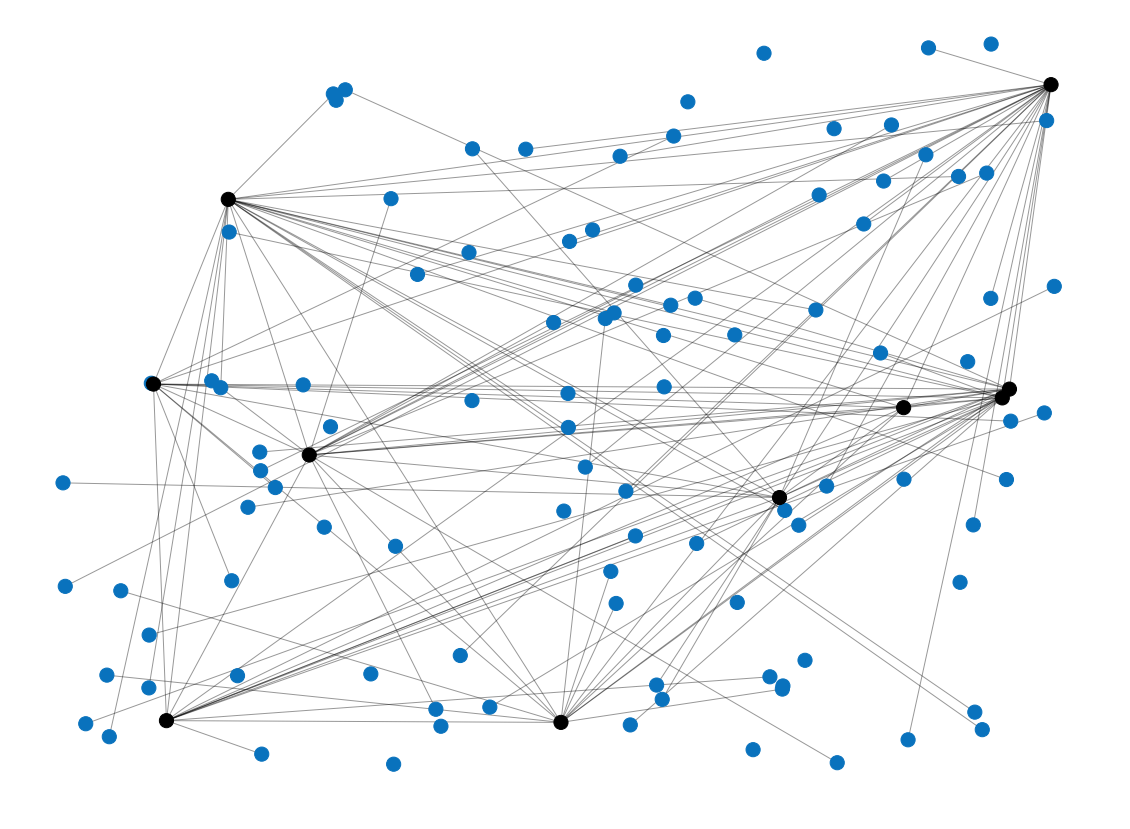

In [12]:
#connect companies for visualization purpose
G.add_edges_from(list (itertools.combinations(company_index, 2)))

for node in G.nodes():
    if node < num_people:
        G.nodes[node]['color'] = "red"
    else:
        G.nodes[node]['color'] = "red"

H = nx.random_geometric_graph(num_people+num_companies, 0.125)
# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(H, "pos")

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

plt.figure(figsize=(20, 15))
nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.4)
        
color_map = ['#0972bd' if x < num_people else 'black' for x in range(num_people+num_companies)]

nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=G.nodes(),
    node_size=200,
    cmap=plt.cm.Reds_r,
    node_color=color_map
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()
G.remove_edges_from(list (itertools.combinations(company_index, 2)))

In [13]:
wealth = [P[i]['money'] for i in range(len(P))]
income = [P[i]['salary'] for i in range(len(P))]

In [14]:
mean_wealth = np.mean(wealth)
sd_wealth = np.sqrt(np.var(wealth))

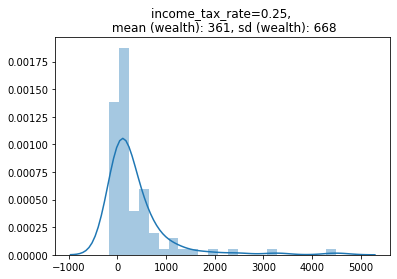

In [15]:
sns.distplot(wealth).set_title(f'income_tax_rate={income_tax_rate}, \n mean (wealth): {int(mean_wealth)}, sd (wealth): {int(sd_wealth)}')
plt.savefig(f"tax={income_tax_rate}.jpg")

In [16]:
np.mean(income), np.sqrt(np.var(income))

(1.5466237403599963, 1.9426196936279143)

In [31]:
#np.mean([C[i]['capital'] for i in range(len(C))])

### simulations varying income tax

In [32]:
lowest_counts = []
less_than = 10

means = []
variances = []

taxes = np.arange(40)/80+0.1

for tax_rate_local in taxes:
    corporate_tax_rate = 0.2

    num_people = 100
    num_companies = 20

    G, P, C, people_index, company_index = initiate(num_people, num_companies)

    for i in range(500):
        G, P, C = evolve(G, P, C, people_index, company_index, tax_rate_local, corporate_tax_rate)

    wealth_local = [P[i]['money'] for i in range(len(P))]
    lowest_counts.append(np.sum(np.array(wealth_local) < less_than))
    
    means.append(np.mean(wealth_local))
    variances.append(np.sqrt(np.var(wealth_local)))

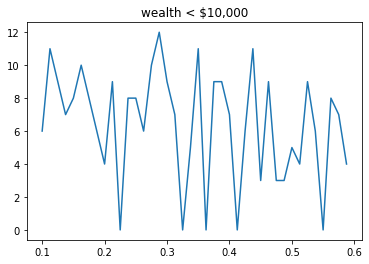

In [33]:
sns.lineplot(taxes, lowest_counts).set_title(f'wealth < ${less_than},000')
plt.savefig(f"less than {less_than}.jpg")

In [68]:
#remove anomalies
upper_limit_mean = np.mean(means)+ 3* np.sqrt(np.var(means))

for i, mean in enumerate(means):
    if mean > upper_limit_mean:
        means [i] = (means [i-1] + means [i+1])/2
        
#remove anomalies
upper_limit_var = np.mean(variances)+ 0.5*np.sqrt(np.var(variances))

for i, variance in enumerate(variances):
    if variance > upper_limit_var:
        variances [i] = (variances[i-1] + variances[i+1])/2

Text(0.5, 1.0, 'mean wealth')

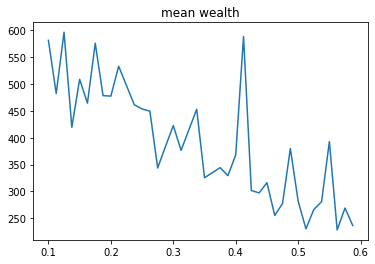

In [71]:
sns.lineplot(taxes, means).set_title(f'mean wealth')

Text(0.5, 1.0, 'standard deviation of wealth')

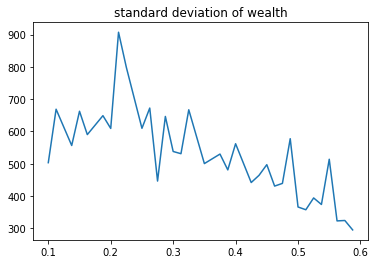

In [72]:
sns.lineplot(taxes, variances).set_title(f'standard deviation of wealth')